# Forecasting air pollutants

In this notebook, we will modify the code to make it suitable for multi-step forecasting.

To perform multi-step forecasting, we will package bits of feature engineering code into Scikit-learn like classes or replace pandas multi-line code by transformers from Feature-engine which work like Scikit-learn classes.

For the Naive forecasting, we will also package the code into a Scikit-learn like estimator, so that we can add the naive forecaster in a pipeline.

If you haven't done so, check the Air Pollutants notebook in Section 2 to familiarize yourself with the feature engineering steps and the forecasting methods we used previously.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import (
    BaseEstimator,
    clone,
    RegressorMixin,
    TransformerMixin, 
)

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from feature_engine.creation import CyclicalTransformer, MathematicalCombination
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures

# Data Preparation

## Load Data

In [2]:
# If you followed the instructions to download the data,
# it should be located here:

filename = '../datasets/AirQualityUCI_ready.csv'

# Load data.
data = pd.read_csv(filename)

In [3]:
# We'll only use sensor data, temperature
# and relative humidity. Thus, we drop all 
# other variables.

drop_vars  = [var for var in data.columns if '_true' in var]
drop_vars.append('AH')

# Remove variables.
data.drop(labels=drop_vars, axis=1, inplace=True)

print(data.shape)

data.head()

(9357, 8)


,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH
0,2004-10-03 18:00:00,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9
1,2004-10-03 19:00:00,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7
2,2004-10-03 20:00:00,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0
3,2004-10-03 21:00:00,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0
4,2004-10-03 22:00:00,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6


## Cast time variable as datetime

In [4]:
# Cast date variable in datetime format.

data['Date_Time'] = pd.to_datetime(data['Date_Time'])

In [5]:
# Set theindex to the timestamp.

data.index = data['Date_Time']

In [6]:
# Sanity: sort index.

data.sort_index(inplace=True)

## Reduce data span

I will narrow down the dataset to those portions with fewer timestamps missing.

In [7]:
# According to plots, narrow down data 
# to the interval with the most data available.

data = data[(
    data['Date_Time'] >= '2004-04-01') &
    (data['Date_Time'] <= '2005-04-30')
]

# Quick check: data span.

data['Date_Time'].agg(['min', 'max'])

min   2004-04-04 00:00:00
max   2005-04-04 14:00:00
Name: Date_Time, dtype: datetime64[ns]

## Remove Outliers

Now, we are going to go ahead and remove those negative values from our dataset.

In [8]:
variables = [var for var in data.columns if var != 'Date_Time']

# replace outliers by NAN

data[data[variables] < 0] = np.nan

data.dropna(inplace=True)

# Feature engineering

In the previous notebook, we engineered most of the features by utilizing pandas. We performed the modifications directly on the original dataset.

This way of engineering features has some limitations. For example, we don't leave behind code to create features from new input data. In fact, we would have to re-write similar code again for every new piece of input data. This is not efficient.

To avoid this, we can create classes with fit and transform functionality that can be easily deployed on new input data to recreate all the features given the new information.

In this notebook, we will wrap the code that creates the features into classes that can be reused.


## Lag Features

I will use the following proxies to predict the next hour's pollutant concentration:

- The pollutant concentration for the previous hour (t-1).

- The pollutant concentration for the same hour on the previous day (t-24).

**We need to be careful because we do not have values for all timestamps. To be safe, we must shift the data using pandas frequency.**

In [9]:
class LagFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, features, frequency, label):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate which features to lag,
        # how much we should lag the variables, 
        # and the name for the new variables.
        
        self.features = features
        self.frequency = frequency
        self.label = label

    def fit(self, X, y=None):

        # We do not need to learn parameters

        return self

    def transform(self, X):

        # We lag the features

        # We make a copy not to over-write the original data
        X = X.copy()

        # Shift the data forward 1 Hr.
        tmp = X[self.features].shift(freq=self.frequency)

        # Name the new variables.
        tmp.columns = [v + self.label for v in self.features]

        # Add the variables to the original data.
        X = X.merge(tmp, left_index=True, right_index=True, how='left')

        return X

## Window features

Window features are mathematical computations of the features' values over a pre-defined time window, prior to the time we want to forecast.

For the demonstration, I will take the average of the previous 3 values of the TS to predict the current value. 

We first need to calculate the average of the 3 previous values, and then move that value forward.

In [10]:
class WindowFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, features, window, frequency):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the features to use for the computation
        # lthe size of the window, and the frequency.
        
        self.features = features
        self.window = window
        self.frequency = frequency

    def fit(self, X, y=None):

        # We do not need to learn parameters

        return self

    def transform(self, X):

        # First we calculate the average of the feature in
        # the indicated window, then we shift the value forward
        # based on the indicated frequency.

        X = X.copy()

        tmp = (X[self.features]
               .rolling(window=self.window).mean()  # Average the last 3 hr values.
               .shift(freq=self.frequency)  # Move the average 1 step forward
               )

        # Rename the columns
        tmp.columns = [v + '_window' for v in self.features]

        X = X.merge(tmp, left_index=True, right_index=True, how='left')

        return X

# Video 3: Seasonality features

In the final part of the notebook, we will train a Linear Regression Model and Random Forests to predict the concentration of each pollutant in the next hour. We will compare the performance of these models with a naive forecast. The naive forecast will be to predict the value of the pollutant concentration at time t, with its concentration at time t-1.

But before that, I want to add some additional features.

We saw that the pollutant concentration has intra day seasonality. So I want to add that information to the dataset. Now this feature is a bit different from the ones we have created so far: this feature needs to learn parameters from the data. Thus, if we use cross-validation, the seasonality should be derived only from the portions of the data used to train the model. 

In order to learn the seasonal parameters from the train set, I will create a transformer class with the methods fit() and transform() and then use it as part of a (Scikit-learn) pipeline.

**Important**: I would like to mention that the pollutant's concentration have no clear trend. For this reason, we can extract seasonal features as I do here. We will talk more about seasonal features in coming sections of the course.

## Seasonality Features

We know that the pollutants have an intra day seasonality. And we want to capture this, using only data in the past, respect to the time of prediction. So we need to create a transformer class that we can use together with Scikit-learn's cross validation functions.

In [11]:
class SeasonalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's 
        # concentration per hour.

        # We make a copy of the dataframe 
        # not to over-write the user's data.
        X = X.copy()

        # Calcualte mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + '_season' for v in self.variables]

        return self

    def transform(self, X):

        # We want to add the seasonal component to the
        # dataset to transform.

        X = X.copy()

        X = X.merge(self.seasonal_, on=self.season_var, how='left')

        return X

In [12]:
# Some hard coded values

lag_1 = ['CO_sensor_lag_1',
         'NMHC_sensor_lag_1',
         'NOX_sensor_lag_1',
         'NO2_sensor_lag_1',
         'O3_sensor_lag_1',
         'T_lag_1',
         'RH_lag_1']

lag_24 = ['CO_sensor_lag_24',
          'NMHC_sensor_lag_24',
          'NOX_sensor_lag_24',
          'NO2_sensor_lag_24',
          'O3_sensor_lag_24',
          'T_lag_24',
          'RH_lag_24']

pollutants = variables[:-2]

In [13]:
engineering_pipe = Pipeline([

    # Extract datetime features
    ('datetime_features', DatetimeFeatures(
        features_to_extract=["month",
                             "week_of_the_year",
                             "day_of_the_week",
                             "day_of_the_month",
                             "hour",
                             "weekend",
                            ],
        drop_original=False)),

    # Create Lag Features
    ('lag_1', LagFeatures(variables, '1H', '_lag_1')),
    ('lag_24', LagFeatures(variables, '24H', '_lag_24')),

    # Create window Features
    ('window_features', WindowFeatures(variables, '3H', '1H')),

    # Combine pollutants
    ('Combine_lag_1', MathematicalCombination(
        variables_to_combine=lag_1,
        math_operations=['sum'],
        new_variables_names=['total_poll_lag_1'],
        missing_values='ignore')),

    ('Combine_lag_24', MathematicalCombination(
        variables_to_combine=lag_24,
        math_operations=['sum'],
        new_variables_names=['total_poll_lag_1'],
        missing_values='ignore')),

    # Create periodic features
    ('Periodic', CyclicalTransformer(
        variables=['Date_Time_month', 'Date_Time_hour'],
        drop_original=False)),

    # Add seasonal features
    ('Seasonal', SeasonalTransformer(
        season_var='Date_Time_hour', variables=pollutants)),

    # Drop missing data
    ('dropna', DropMissingData(missing_only=True)),

])

In [14]:
data.shape

(7380, 8)

In [15]:
data_t = engineering_pipe.fit_transform(data)

data_t.shape

(6894, 45)

In [16]:
data.head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH
Date_Time,,,,,,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,892.0,884.0,1580.0,923.0,16.7,56.5
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,843.0,929.0,1551.0,862.0,15.9,59.2
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,782.0,980.0,1500.0,752.0,15.2,62.4
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,793.0,965.0,1521.0,791.0,14.7,65.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,682.0,1090.0,1448.0,697.0,14.3,65.3


# Train and evaluate models

## Separate into train and test

We will train the model on a certain portion of the data and leave another part out to evaluate the model.

Because these are time series, I prefer not to do a random split but to split based on time.

In [17]:
# Find minimum and maximum dates.

data.index.min(), data.index.max()

(Timestamp('2004-04-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [18]:
# We will keep the last month of data to test
# The forecasting models

X_train = data[data.index<='2005-03-04']
X_test = data[data.index>'2005-03-04']

X_train.shape, X_test.shape

((6838, 8), (542, 8))

## Our variables

Let's remind ourselves which variables we have in our data.

In [19]:
# These are the pollutants plus temperature and humidity.
# That is, the original data.

variables

['CO_sensor',
 'NMHC_sensor',
 'NOX_sensor',
 'NO2_sensor',
 'O3_sensor',
 'T',
 'RH']

In [20]:
# These are the pollutants's original values.
# That is, the raw time series.

pollutants

['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor']

In [21]:
# Now I capture the input variables, that is
# the features we crated to predict pollutant 
# concentration at time t.

features = [v for v in data_t.columns if v not in variables and v != 'Date_Time']

features

['Date_Time_month',
 'Date_Time_woty',
 'Date_Time_dotw',
 'Date_Time_dotm',
 'Date_Time_hour',
 'Date_Time_weekend',
 'CO_sensor_lag_1',
 'NMHC_sensor_lag_1',
 'NOX_sensor_lag_1',
 'NO2_sensor_lag_1',
 'O3_sensor_lag_1',
 'T_lag_1',
 'RH_lag_1',
 'CO_sensor_lag_24',
 'NMHC_sensor_lag_24',
 'NOX_sensor_lag_24',
 'NO2_sensor_lag_24',
 'O3_sensor_lag_24',
 'T_lag_24',
 'RH_lag_24',
 'CO_sensor_window',
 'NMHC_sensor_window',
 'NOX_sensor_window',
 'NO2_sensor_window',
 'O3_sensor_window',
 'T_window',
 'RH_window',
 'total_poll_lag_1',
 'Date_Time_month_sin',
 'Date_Time_month_cos',
 'Date_Time_hour_sin',
 'Date_Time_hour_cos',
 'CO_sensor_season',
 'NMHC_sensor_season',
 'NOX_sensor_season',
 'NO2_sensor_season',
 'O3_sensor_season']

In [22]:
# And these are the variables that should not be
# in the training set.

vars_to_drop = [v for v in data_t.columns if v not in features]

vars_to_drop

['Date_Time',
 'CO_sensor',
 'NMHC_sensor',
 'NOX_sensor',
 'NO2_sensor',
 'O3_sensor',
 'T',
 'RH']

## Naive Forecast

We will predict the pollutant's concentration at time t with its value at time t-1. We will use this model as a benchmark. We will compare the results of the Random Forests and Linear Regression against this benchmark.

In [23]:
class NaiveForecast(BaseEstimator, RegressorMixin):

    def __init__(self, predictor_var):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.predictor_var = predictor_var

    def fit(self, X, y):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        return self

    def predict(self, X):

        # We want to add the seasonal component to the
        # dataset to transform.

        return X[self.predictor_var]

In [24]:
naive_pipe = Pipeline([
    
    # create seasonal features
    ('feature_engineering', engineering_pipe),
        
    # random forests
    ('naive', NaiveForecast(predictor_var='CO_sensor_lag_1')),
    
])

24      1188.0
25      1065.0
26       999.0
27       911.0
28       873.0
         ...  
6833    1473.0
6834    1396.0
6835    1285.0
6836    1206.0
6837    1179.0
Name: CO_sensor_lag_1, Length: 6400, dtype: float64

In [26]:
# And now, we make a naive forecast over the
# X_test. That is the left-out sample.

print('X_train rmse: ',
      mean_squared_error(
          X_train['CO_sensor'], naive_pipe.predict(X_train), squared=False,
      ))

ValueError: Found input variables with inconsistent numbers of samples: [6838, 6400]

In [27]:
print('X_test rmse: ',
      mean_squared_error(
          X_test['CO_sensor'], naive_pipe.predict(X_test), squared=False,
      ))

ValueError: Found input variables with inconsistent numbers of samples: [542, 471]

In [28]:
naive_window = NaiveForecast(predictor_var='CO_sensor_window')

naive_window.fit(X_train, X_train['CO_sensor'])

NaiveForecast(predictor_var='CO_sensor_window')

In [29]:
print('X_train rmse: ',
      mean_squared_error(
          X_train['CO_sensor'], naive_window.predict(X_train), squared=False,
      ))

X_train rmse:  141.9165813545692


In [30]:
print('X_test rmse: ',
      mean_squared_error(
          X_test['CO_sensor'], naive_window.predict(X_test), squared=False,
      ))

X_test rmse:  157.87850718808693


For fun, go ahead and try making predictions with another feature, for example the lag 24 version.

## Linear Regression

Random Forest regression models are not very good at extrapolating values beyond those observed in the data. So let's now train a machine learning pipeline with a Lasso regression for comparison.

In [28]:
pipe = Pipeline([
    
    # create seasonal features
    ('feature_engineering', engineering_pipe),
    
    # drop original (raw) variables. These are only 
    # needed to capture the seasonality.
    ('drop_vars', DropFeatures(features_to_drop=vars_to_drop)),
    
    # scaler
    ('scaler', MinMaxScaler()),
    
    # random forests
    ('lasso', Lasso(random_state=0)),    
])

In [29]:
pipe.fit(X_train, X_train['CO_sensor'])

ValueError: Found input variables with inconsistent numbers of samples: [6400, 6838]

In [59]:
print('X_train rmse: ',
      mean_squared_error(
          X_train['CO_sensor'], pipe.predict(X_train), squared=False,
      ))

X_train rmse:  92.29666857689399


In [60]:
print('X_test rmse: ',
      mean_squared_error(
          X_test['CO_sensor'], pipe.predict(X_test), squared=False,
      ))

X_test rmse:  93.5892259957662


We can see an uplift with respect to the Naive forecast and also the Random Forests.

## All Models

In [69]:
linear_dict = {}

for pollutant in pollutants:
    
    pipe_ = clone(pipe)

    linear_dict[pollutant] = pipe_.fit(X_train, X_train[pollutant])

In [71]:
naive_dict = {}

for pollutant in pollutants:
    
    naive = NaiveForecast(predictor_var= pollutant +'_lag_1')
    
    naive_dict[pollutant] = naive

## Split test set

In [133]:
# split a test set into 24 step chunks

def split_dataset(data):
    
    data = data.copy()
    
    data = data.set_index(data.index).asfreq('1H')
    
    # split into 24 point chunks
    test = np.array(np.array_split(data,len(data)/23))
                    
    return test

In [134]:
test = split_dataset(X_test)

len(test)

<ipython-input-133-376fdf529767>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(np.array_split(data,len(data)/23))


32

In [135]:
test[0]

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,Month,Week,...,NO2_sensor_window,O3_sensor_window,T_window,RH_window,total_poll_lag_1,total_poll_lag_24,Month_sin,Month_cos,Hour_sin,Hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-04 01:00:00,2005-03-04 01:00:00,951.0,642.0,895.0,929.0,666.0,12.7,40.8,3.0,9,...,1112.666667,1023.000000,7.500000,67.300000,3991.9,4811.7,1.0,6.123234e-17,2.697968e-01,0.962917
2005-03-04 02:00:00,2005-03-04 02:00:00,938.0,631.0,882.0,931.0,679.0,12.0,44.2,3.0,9,...,1010.666667,816.666667,10.200000,53.400000,4136.5,4681.7,1.0,6.123234e-17,5.195840e-01,0.854419
2005-03-04 03:00:00,2005-03-04 03:00:00,921.0,642.0,861.0,948.0,768.0,10.5,48.7,3.0,9,...,919.333333,629.666667,12.733333,40.800000,4117.2,4683.3,1.0,6.123234e-17,7.308360e-01,0.682553
2005-03-04 04:00:00,2005-03-04 04:00:00,850.0,583.0,955.0,914.0,589.0,10.1,49.7,3.0,9,...,936.000000,704.333333,11.733333,44.566667,4199.2,5028.7,1.0,6.123234e-17,8.878852e-01,0.460065
2005-03-04 05:00:00,2005-03-04 05:00:00,811.0,494.0,1118.0,872.0,470.0,9.6,51.0,3.0,9,...,931.000000,678.666667,10.866667,47.533333,3950.8,5075.8,1.0,6.123234e-17,9.790841e-01,0.203456
2005-03-04 06:00:00,2005-03-04 06:00:00,848.0,530.0,1072.0,901.0,523.0,9.1,52.4,3.0,9,...,911.333333,609.000000,10.066667,49.800000,3825.6,5218.9,1.0,6.123234e-17,9.976688e-01,-0.068242
2005-03-04 07:00:00,2005-03-04 07:00:00,882.0,563.0,978.0,936.0,660.0,8.9,52.7,3.0,9,...,895.666667,527.333333,9.600000,51.033333,3935.5,5392.5,1.0,6.123234e-17,9.422609e-01,-0.334880
2005-03-04 08:00:00,2005-03-04 08:00:00,936.0,611.0,911.0,949.0,741.0,13.5,40.0,3.0,9,...,903.000000,551.000000,9.200000,52.033333,4080.6,6403.2,1.0,6.123234e-17,8.169699e-01,-0.576680
2005-03-04 09:00:00,2005-03-04 09:00:00,1022.0,715.0,806.0,1004.0,831.0,17.8,30.7,3.0,9,...,928.666667,641.333333,10.500000,48.366667,4201.5,6296.1,1.0,6.123234e-17,6.310879e-01,-0.775711


In [137]:
test[4]

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,Month,Week,...,NO2_sensor_window,O3_sensor_window,T_window,RH_window,total_poll_lag_1,total_poll_lag_24,Month_sin,Month_cos,Hour_sin,Hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-08 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08 05:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08 06:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08 07:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08 08:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-08 09:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
test[10]

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,Month,Week,...,NO2_sensor_window,O3_sensor_window,T_window,RH_window,total_poll_lag_1,total_poll_lag_24,Month_sin,Month_cos,Hour_sin,Hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-14 01:00:00,2005-03-14 01:00:00,1128.0,771.0,733.0,1178.0,923.0,11.7,62.1,3.0,11,...,1182.333333,1084.333333,13.366667,54.533333,4524.1,4235.3,1.0,6.123234e-17,2.697968e-01,0.962917
2005-03-14 02:00:00,2005-03-14 02:00:00,1119.0,778.0,705.0,1187.0,1096.0,9.9,68.9,3.0,11,...,1160.000000,977.333333,12.700000,57.866667,4806.8,4243.8,1.0,6.123234e-17,5.195840e-01,0.854419
2005-03-14 03:00:00,2005-03-14 03:00:00,1077.0,701.0,761.0,1122.0,1106.0,9.8,68.0,3.0,11,...,1150.000000,949.000000,11.600000,62.300000,4963.8,3936.5,1.0,6.123234e-17,7.308360e-01,0.682553
2005-03-14 04:00:00,2005-03-14 04:00:00,1036.0,636.0,845.0,1084.0,976.0,8.9,71.9,3.0,11,...,1162.333333,1041.666667,10.466667,66.333333,4844.8,3948.9,1.0,6.123234e-17,8.878852e-01,0.460065
2005-03-14 05:00:00,2005-03-14 05:00:00,1016.0,647.0,824.0,1090.0,937.0,8.4,74.5,3.0,11,...,1131.000000,1059.333333,9.533333,69.600000,4657.8,3950.2,1.0,6.123234e-17,9.790841e-01,0.203456
2005-03-14 06:00:00,2005-03-14 06:00:00,1103.0,730.0,735.0,1139.0,1049.0,9.2,71.0,3.0,11,...,1098.666667,1006.333333,9.033333,71.466667,4596.9,3842.4,1.0,6.123234e-17,9.976688e-01,-0.068242
2005-03-14 07:00:00,2005-03-14 07:00:00,1176.0,880.0,634.0,1257.0,1180.0,9.9,67.6,3.0,11,...,1104.333333,987.333333,8.833333,72.466667,4836.2,3988.1,1.0,6.123234e-17,9.422609e-01,-0.334880
2005-03-14 08:00:00,2005-03-14 08:00:00,1430.0,1169.0,481.0,1543.0,1514.0,10.8,64.4,3.0,11,...,1162.000000,1055.333333,9.166667,71.033333,5204.5,4061.3,1.0,6.123234e-17,8.169699e-01,-0.576680
2005-03-14 09:00:00,2005-03-14 09:00:00,1572.0,1374.0,411.0,1763.0,1771.0,11.7,61.7,3.0,11,...,1313.000000,1247.666667,9.966667,67.666667,6212.2,4269.8,1.0,6.123234e-17,6.310879e-01,-0.775711


In [138]:
to_delete = []

for i in range(len(test)):
    if test[i].isnull().any().any():
        to_delete.append(i)

to_delete

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 28, 29, 30]

In [139]:
print(len(test))

test = np.delete(test, to_delete)

print(len(test))

32

## Moving Forward in the Horizon

Let's compare the predictions of the 3 models by plotting the predictions against the truth.

The linear regression model was able to capture more value from the features in the data to forecast. Maybe this is why we see a small uplift respect to Random Forests.

In [72]:
X_pred = pd.DataFrame()
X_pred_naive = pd.DataFrame()

for pollutant in pollutants:
    
    X_pred[pollutant] = linear_dict[pollutant].predict(X_test)
    
    X_pred_naive[pollutant] = naive_dict[pollutant].predict(X_test)

In [75]:
X_pred.index = X_test.index

X_pred_naive.index = X_test.index

In [76]:
X_pred

,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor
Date_Time,,,,,
2005-03-04 01:00:00,907.133201,588.431967,992.265151,883.878006,532.789253
2005-03-04 02:00:00,914.176228,602.876476,958.198994,921.181230,638.627587
2005-03-04 03:00:00,899.323717,590.529036,954.553444,936.054690,651.999328
2005-03-04 04:00:00,892.638337,610.148895,934.613684,958.459318,736.681832
2005-03-04 05:00:00,845.082412,570.154883,1001.071922,942.097601,592.307264
...,...,...,...,...,...
2005-04-04 10:00:00,1277.521124,1125.008840,545.442734,1382.403827,1517.802521
2005-04-04 11:00:00,1276.696367,1125.597961,587.788212,1376.302655,1622.657844
2005-04-04 12:00:00,1155.101076,1043.191890,646.993262,1306.035958,1238.174689


In [79]:
# Introduce the missing timestamps.
# Note that we capture this in a different variable.

X_pred = X_pred.set_index(X_pred.index).asfreq('1H')

X_pred_naive = X_pred_naive.set_index(X_pred_naive.index).asfreq('1H')

print(X_pred.shape, X_test.shape)

(758, 5) (494, 41)


In [66]:
X_test_.head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,Month,Week,...,NO2_sensor_window,O3_sensor_window,T_window,RH_window,total_poll_lag_1,total_poll_lag_24,Month_sin,Month_cos,Hour_sin,Hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-04 01:00:00,2005-03-04 01:00:00,951.0,642.0,895.0,929.0,666.0,12.7,40.8,3.0,9,...,1112.666667,1023.000000,7.500000,67.300000,3991.9,4811.7,1.0,6.123234e-17,0.269797,0.962917
2005-03-04 02:00:00,2005-03-04 02:00:00,938.0,631.0,882.0,931.0,679.0,12.0,44.2,3.0,9,...,1010.666667,816.666667,10.200000,53.400000,4136.5,4681.7,1.0,6.123234e-17,0.519584,0.854419
2005-03-04 03:00:00,2005-03-04 03:00:00,921.0,642.0,861.0,948.0,768.0,10.5,48.7,3.0,9,...,919.333333,629.666667,12.733333,40.800000,4117.2,4683.3,1.0,6.123234e-17,0.730836,0.682553
2005-03-04 04:00:00,2005-03-04 04:00:00,850.0,583.0,955.0,914.0,589.0,10.1,49.7,3.0,9,...,936.000000,704.333333,11.733333,44.566667,4199.2,5028.7,1.0,6.123234e-17,0.887885,0.460065
2005-03-04 05:00:00,2005-03-04 05:00:00,811.0,494.0,1118.0,872.0,470.0,9.6,51.0,3.0,9,...,931.000000,678.666667,10.866667,47.533333,3950.8,5075.8,1.0,6.123234e-17,0.979084,0.203456


# Video 5: Multi-series predictions

Now, to make it a tiny bit more real, we will train models to forecast the concentration of every pollutant.

In [77]:
# We will clone the pipeline so that we 
# do not retrain te same object every time
from sklearn.base import clone

# clone allows us to create multiple identical pipelines

In [78]:
pollutants

['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor']

## Train models with CV

In [79]:
# We store the trained pipelines in a 
# dictionary
models = {}

# For comparison, we will also store
# the predictions from our naive forecast
naive_forecast ={}

for pollutant in pollutants:

    # clone the pipeline
    pipe_int = clone(pipe)

    # train the model with cross-val
    cv_results = cross_validate(
        estimator=pipe_int,
        X=X_train,
        y=X_train[pollutant],
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        return_train_score=True,
        return_estimator=True,
    )

    # store the results
    models[pollutant] = cv_results
    
    # ============
    # Naive forecast
    naive_forecast[pollutant] = naive_cv(X_train, pollutant)
    

## Evaluate models

In [80]:
# Print the model performance for each pollutant

for pollutant in pollutants:

    print(pollutant)
    # Randon Forests
    cv_results = models[pollutant]

    print('RF: train rmse: ', np.mean(
        cv_results['train_score']), '+-', np.std(cv_results['train_score']))
    print('RF: test rmse: ', np.mean(
        cv_results['test_score']), '+-', np.std(cv_results['test_score']))

    # Naive Forecast
    rmse_train, rmse_test = naive_forecast[pollutant]

    print('Naive: train rmse: ', np.mean(rmse_train), '+-', np.std(rmse_train))
    print('Naive: test rmse: ', np.mean(rmse_test), '+-', np.std(rmse_test))
    print()

CO_sensor
RF: train rmse:  -96.5037316396324 +- 3.234781696673297
RF: test rmse:  -96.39220687933657 +- 8.423362793980937
Naive: train rmse:  108.99963315823713 +- 4.948601006879665
Naive: test rmse:  98.2508259523338 +- 6.933898592005048

NMHC_sensor
RF: train rmse:  -117.8398897632776 +- 4.446506099451743
RF: test rmse:  -122.75341049356773 +- 17.797817437492462
Naive: train rmse:  143.9538361528611 +- 3.7804184715003935
Naive: test rmse:  133.74383335274914 +- 8.900383799518735

NOX_sensor
RF: train rmse:  -107.9611880035424 +- 3.0731608551079685
RF: test rmse:  -115.39500498796026 +- 12.700077551052553
Naive: train rmse:  115.00653822545286 +- 2.072074271433866
Naive: test rmse:  113.5106285551066 +- 4.682782829111106

NO2_sensor
RF: train rmse:  -134.28959742341547 +- 2.6955371846509744
RF: test rmse:  -138.32175594573667 +- 13.195622309967426
Naive: train rmse:  160.7233246147259 +- 5.115007989621346
Naive: test rmse:  139.23421220030684 +- 15.689718861723577

O3_sensor
RF: train

## Feature's importance

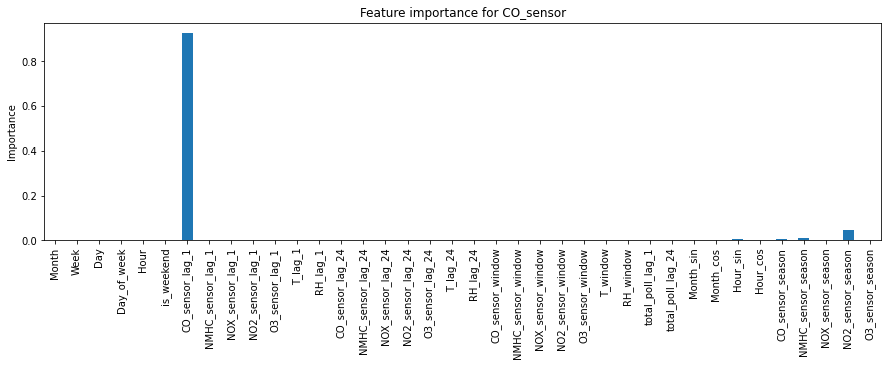

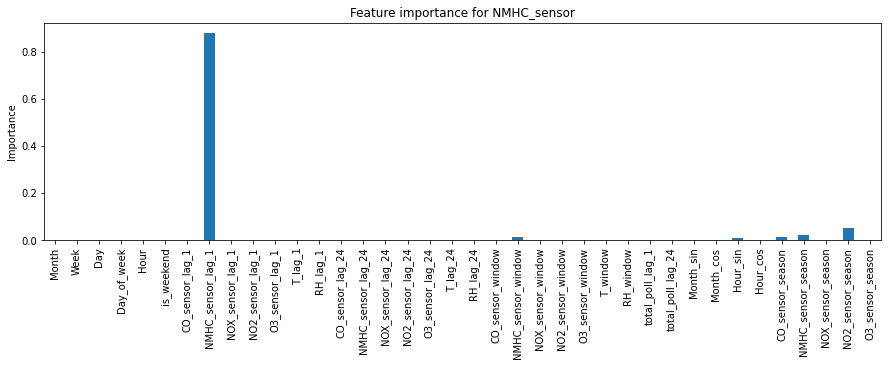

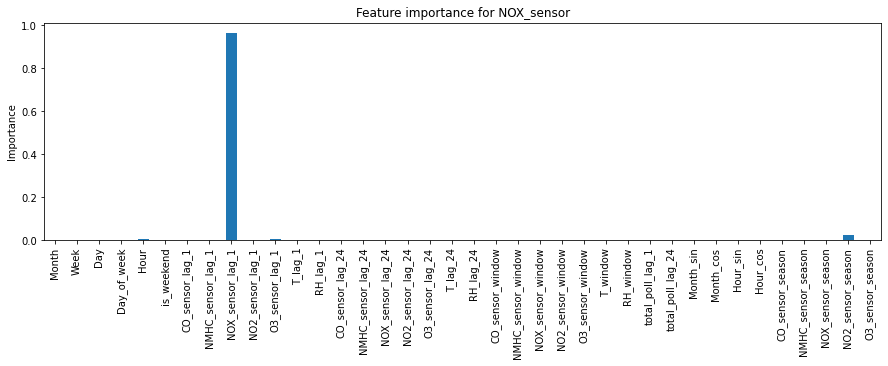

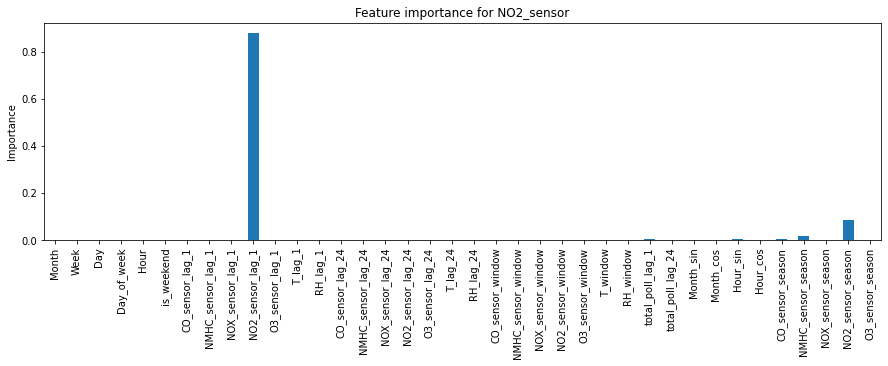

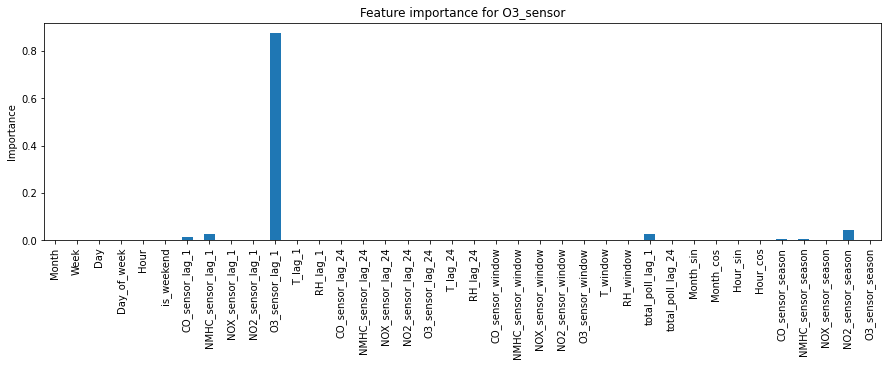

In [81]:
# For every model we plot the feature's importance.

for pollutant in pollutants:
    
    cv_results = models[pollutant]

    tmp = pd.Series(cv_results['estimator']
                    [0].named_steps['rf'].feature_importances_)

    tmp.index = input_variables + ['CO_sensor_season',
     'NMHC_sensor_season',
     'NOX_sensor_season',
     'NO2_sensor_season',
     'O3_sensor_season']

    tmp.plot.bar(figsize=(15,4))
    plt.title('Feature importance for ' + pollutant)
    plt.ylabel('Importance')
    plt.show()

CO_sensor
RMSE: 102.88062933604054


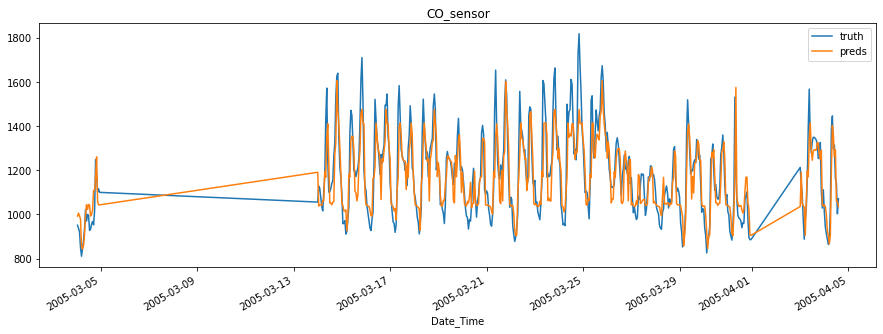

NMHC_sensor
RMSE: 121.1108741114408


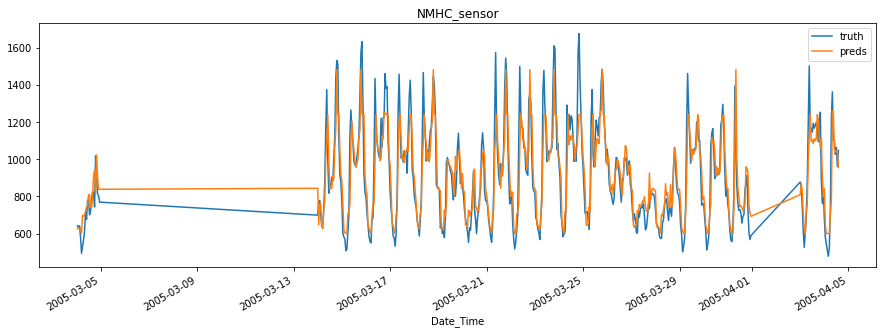

NOX_sensor
RMSE: 91.93402395361085


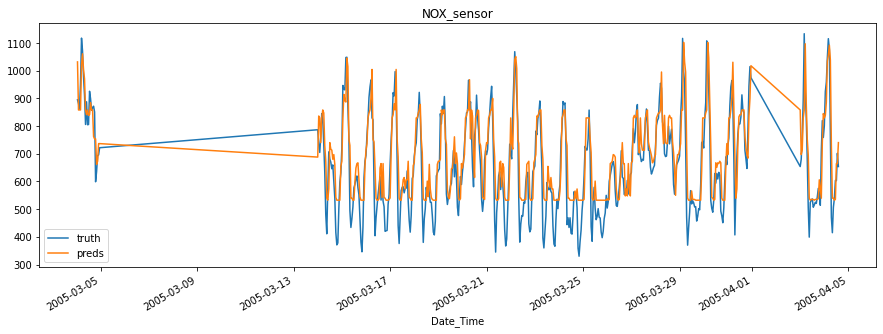

NO2_sensor
RMSE: 151.90799590928864


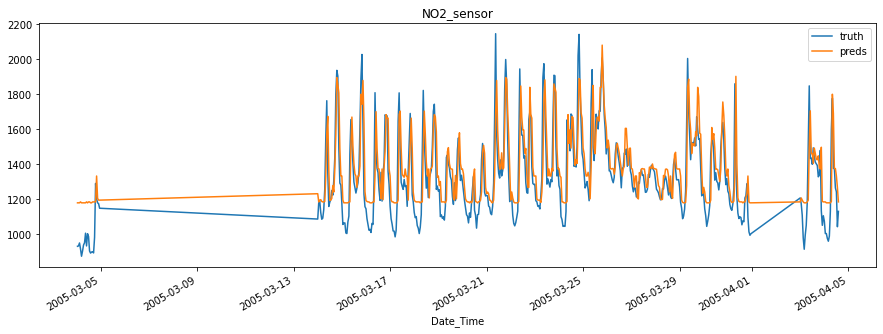

O3_sensor
RMSE: 193.30112291039543


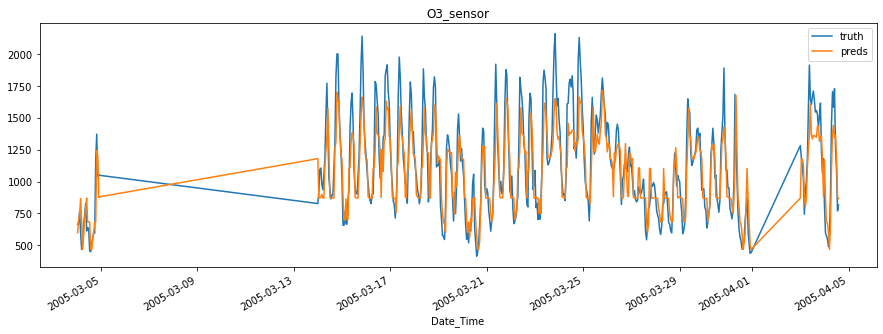

In [82]:
# To finish off, we will test the model on the
# test set

for pollutant in pollutants:
    
    cv_results = models[pollutant]
    
    # make predictions
    preds = cv_results['estimator'][0].predict(X_test)

    # determine rmse
    rmse = mean_squared_error(X_test[pollutant], preds, squared=False)
    
    print(pollutant)
    print('RMSE:', rmse )

    # plot the predictions
    tmp = pd.concat([
        X_test[pollutant].reset_index(drop=True),
        pd.Series(preds),
        ], axis=1)

    tmp.columns = ['truth', 'preds']

    tmp.index = X_test.index

    tmp.plot(figsize=(15,5))
    plt.title(pollutant)
    plt.show()

In general, the models look OK. They tend to be more conservative, not predicting the lowest or highest pollutant concentrations with good accuracy.

This is just a demo to get you started with feature engineering, though.

That is all for this notebook. I hope you enjoyed it!